<style>
pre {
 white-space: pre-wrap !important;
}
.table-striped > tbody > tr:nth-of-type(odd) {
    background-color: #f9f9f9;
}
.table-striped > tbody > tr:nth-of-type(even) {
    background-color: white;
}
.table-striped td, .table-striped th, .table-striped tr {
    border: 1px solid black;
    border-collapse: collapse;
    margin: 1em 2em;
}
.rendered_html td, .rendered_html th {
    text-align: left;
    vertical-align: middle;
    padding: 4px;
}
</style>

# Machine Learning (basic): the Iris dataset

If you want to try out this notebook with a live Python kernel, use mybinder:

<a class="reference external image-reference" href="https://mybinder.org/v2/gh/vaexio/vaex/latest?filepath=docs%2Fsource%2Fexample_ml_iris.ipynb"><img alt="https://mybinder.org/badge_logo.svg" src="https://mybinder.org/badge_logo.svg" width="150px"></a>

While `vaex.ml` does not yet implement predictive models, we provide wrappers to powerful libraries (e.g. [Scikit-learn](https://scikit-learn.org/), [xgboost](https://xgboost.readthedocs.io/)) and make them work efficiently with `vaex`. `vaex.ml` does implement a variety of standard data transformers (e.g. PCA, numerical scalers, categorical encoders) and a very efficient KMeans algorithm that take full advantage of `vaex`.

The following is a simple example on use of `vaex.ml`. We will be using the well known Iris dataset, and we will use it to build a model which distinguishes between the three Irish species ([Iris setosa](https://en.wikipedia.org/wiki/Iris_setosa), [Iris virginica](https://en.wikipedia.org/wiki/Iris_virginica) and [Iris versicolor](https://en.wikipedia.org/wiki/Iris_versicolor)).

Lets start by importing the common libraries, load and inspect the data.

In [1]:
import vaex
import vaex.ml

import pylab as plt


df = vaex.ml.datasets.load_iris()
df

#,sepal_length,sepal_width,petal_length,petal_width,class_
0,5.9,3.0,4.2,1.5,1
1,6.1,3.0,4.6,1.4,1
2,6.6,2.9,4.6,1.3,1
3,6.7,3.3,5.7,2.1,2
4,5.5,4.2,1.4,0.2,0
...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0
146,5.1,3.8,1.6,0.2,0
147,5.8,2.6,4.0,1.2,1
148,5.7,3.8,1.7,0.3,0


Splitting the data into _train_ and _test_ steps should be done immediately, before any manipulation is done on the data. `vaex.ml` contains a `train_test_split` method which creates shallow copies of the main DataFrame, meaning that no extra memory is used when defining train and test sets. Note that the `train_test_split` method does an ordered split of the main DataFrame to create the two sets. In some cases, one may need to shuffle the data.

If shuffling is required, we recommend the following:
```
df.export("shuffled", shuffle=True)
df = vaex.open("shuffled.hdf5)
df_train, df_test = df.ml.train_test_split(test_size=0.2)
```

In the present scenario, the dataset is already shuffled, so we can simply do the split right away.

In [2]:
# Orderd split in train and test
df_train, df_test = df.ml.train_test_split(test_size=0.2)

/Users/jovan/PyLibrary/vaex/packages/vaex-core/vaex/ml/__init__.py:209: UserWarning: Make sure the DataFrame is shuffled
  warnings.warn('Make sure the DataFrame is shuffled')


As this is a very simple tutorial, we will just use the columns already provided as features for training the model.

In [3]:
features = df_train.column_names[:4]
features

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

## PCA

The `vaex.ml` module contains several classes for dataset transformations that are commonly used to pre-process data prior to building a model. These include numerical feature scalers, category encoders, and [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) transformations. We have adopted the [scikit-learn](https://scikit-learn.org/stable/) API, meaning that all transformers have the `.fit` and `.transform` methods. 

Let's use apply a PCA transformation on the training set. There is no need to scale the data beforehand, since the PCA also normalizes the data.

In [4]:
pca = vaex.ml.PCA(features=features, n_components=4)
df_train = pca.fit_transform(df_train)
df_train

#,sepal_length,sepal_width,petal_length,petal_width,class_,PCA_0,PCA_1,PCA_2,PCA_3
0,5.4,3.0,4.5,1.5,1,-0.5819340944906611,-0.5192084328455534,-0.4079706950207428,-0.22843325658378022
1,4.8,3.4,1.6,0.2,0,2.628040487885542,-0.05578001049524599,-0.09961452867004605,-0.14960589756342935
2,6.9,3.1,4.9,1.5,1,-1.438496521671396,0.5307778852279289,0.32322065776316616,-0.0066478967991949744
3,4.4,3.2,1.3,0.2,0,3.00633586736142,-0.41909744036887703,-0.17571839830952185,-0.05420541515837107
4,5.6,2.8,4.9,2.0,2,-1.1948465297428466,-0.6200295372229213,-0.4751905348367903,0.08724845774327505
...,...,...,...,...,...,...,...,...,...
115,5.2,3.4,1.4,0.2,0,2.6608856211270933,0.2619681501203415,0.12886483875694454,0.06429707648769989
116,5.1,3.8,1.6,0.2,0,2.561545765055359,0.4288927940763031,-0.18633294617759266,-0.20573646329612738
117,5.8,2.6,4.0,1.2,1,-0.22075578997244774,-0.40152336651555137,0.25417836518749715,0.04952191889168374
118,5.7,3.8,1.7,0.3,0,2.23068249078231,0.826166758833374,0.07863720599424912,0.0004035597987264161


The result of pca `.fit_transform` method is a shallow copy of the DataFrame which contains the resulting columns of the transformation, in this case the PCA components, as virtual columns. This means that the transformed DataFrame takes no memory at all! So while this example is made with only 120 sample, this would work in the same way even for millions or billions of samples.

## Gradient boosting trees

Now let's train a gradient boosting model. While `vaex.ml` does not currently include this type of models, we support the popular boosted trees libraries [xgboost](https://xgboost.readthedocs.io/en/latest/), [lightgbm](https://lightgbm.readthedocs.io/en/latest/), and [catboost](https://catboost.ai/). In this tutorial we will use the `lightgbm` classifier.

In [9]:
import lightgbm
import vaex.ml.sklearn

# Features on which to train the model
train_features = df_train.get_column_names(regex='PCA_.*')
# The target column
target = 'class_'

# Instantiate the LightGBM Classifier
booster = lightgbm.sklearn.LGBMClassifier(num_leaves=5, 
                                          max_depth=5, 
                                          n_estimators=100,
                                          random_state=42)

# Make it a vaex transformer (for the automagic pipeline and lazy predictions)
model = vaex.ml.sklearn.Predictor(features=train_features, 
                                  target=target,
                                  model=booster, 
                                  prediction_name='prediction')

# Train and predict
model.fit(df=df_train)
df_train = model.transform(df=df_train)

df_train

#,sepal_length,sepal_width,petal_length,petal_width,class_,PCA_0,PCA_1,PCA_2,PCA_3,prediction
0,5.4,3.0,4.5,1.5,1,-0.5819340944906611,-0.5192084328455534,-0.4079706950207428,-0.22843325658378022,1
1,4.8,3.4,1.6,0.2,0,2.628040487885542,-0.05578001049524599,-0.09961452867004605,-0.14960589756342935,0
2,6.9,3.1,4.9,1.5,1,-1.438496521671396,0.5307778852279289,0.32322065776316616,-0.0066478967991949744,1
3,4.4,3.2,1.3,0.2,0,3.00633586736142,-0.41909744036887703,-0.17571839830952185,-0.05420541515837107,0
4,5.6,2.8,4.9,2.0,2,-1.1948465297428466,-0.6200295372229213,-0.4751905348367903,0.08724845774327505,2
...,...,...,...,...,...,...,...,...,...,...
115,5.2,3.4,1.4,0.2,0,2.6608856211270933,0.2619681501203415,0.12886483875694454,0.06429707648769989,0
116,5.1,3.8,1.6,0.2,0,2.561545765055359,0.4288927940763031,-0.18633294617759266,-0.20573646329612738,0
117,5.8,2.6,4.0,1.2,1,-0.22075578997244774,-0.40152336651555137,0.25417836518749715,0.04952191889168374,1
118,5.7,3.8,1.7,0.3,0,2.23068249078231,0.826166758833374,0.07863720599424912,0.0004035597987264161,0


Notice that after training the model, we use the `.transform` method to obtain a shallow copy of the DataFrame which  contains the prediction of the model, in a form of a virtual column. This makes it easy to evaluate the model, and easily create various diagnostic plots. If required, one can call the `.predict` method, which will result in an in-memory `numpy.array` housing the predictions.

## Automatic pipelines

Assuming we are happy with the performance of the model, we can continue and apply our transformations and model to the test set. Unlike other libraries, we do not need to explicitly create a pipeline here in order to propagate the transformations. In fact, with `vaex` and `vaex.ml`, a pipeline is automatically being created as one is doing the exploration of the data. Each `vaex` DataFrame contains a _state,_ which is a (serializable) object containing information of all transformations applied to the DataFrame (filtering, creation of new virtual columns, transformations).

Recall that the outputs of both the PCA transformation and the boosted model were in fact virtual columns, and thus are stored in the state of `df_train`. All we need to do, is to apply this state to another similar DataFrame (e.g. the test set), and all the changes will be propagated.

In [6]:
state = df_train.state_get()
df_test.state_set(state)

df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,PCA_0,PCA_1,PCA_2,PCA_3,prediction
0,5.9,3.0,4.2,1.5,1,-0.4978687101343986,-0.11289245880584761,-0.11962601206069637,0.0625954090178564,1
1,6.1,3.0,4.6,1.4,1,-0.8754765898560835,-0.03902402119573594,0.022944044447894815,-0.14143773065379384,1
2,6.6,2.9,4.6,1.3,1,-1.0228803632878913,0.2503709022470443,0.4130613754204865,-0.030391911559003282,1
3,6.7,3.3,5.7,2.1,2,-2.2544508624315838,0.3431374410700749,-0.28908707579214765,-0.07059175451207655,2
4,5.5,4.2,1.4,0.2,0,2.632289228948536,1.020394958612415,-0.20769510079946696,-0.13744144140286718,0
...,...,...,...,...,...,...,...,...,...,...
25,5.5,2.5,4.0,1.3,1,-0.16189655085432594,-0.6871827581512436,0.09773053160021669,0.07093166682594204,1
26,5.8,2.7,3.9,1.2,1,-0.12526327170089271,-0.3148233189949767,0.19720893202789733,0.060419826927667064,1
27,4.4,2.9,1.4,0.2,0,2.8918941837640526,-0.6426744898497139,0.006171795874510444,0.007700652884580328,0
28,4.5,2.3,1.3,0.3,0,2.850207707200544,-0.9710397723109179,0.38501428492268475,0.377723418991853,0


## Production

Now `df_test` contains all the transformations we applied on the training set (`df_train`), including the model prediction. The transfer of state from one DataFrame to another can be extremely valuable for putting models in production.

## Performance
Finally, let's check the model performance.

In [7]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true=df_test.class_.values, y_pred=df_test.prediction.values)
acc *= 100.
print(f'Test set accuracy: {acc}%')

Test set accuracy: 100.0%


The model get perfect accuracy of 100%. This is not surprising as this problem is rather easy: doing a PCA transformation on the features nicely separates the 3 flower species. Plotting the first two PCA axes, and colouring the samples according to their class already shows an almost perfect separation.

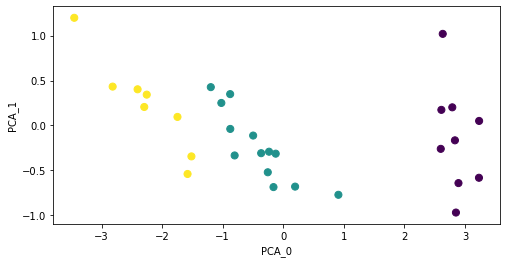

In [8]:
plt.figure(figsize=(8, 4))
df_test.scatter(df_test.PCA_0, df_test.PCA_1, c_expr=df_test.class_, s=50)
plt.show()